In [1]:
import torch
from pygel3d import hmesh, graph, jupyter_display as jd
import numpy as np
import pymde
from tqdm import tqdm

limit = 70000

mnist = pymde.datasets.MNIST()
tensor = torch.load("tensor.pt")[:limit]
nparr = tensor.numpy()

ModuleNotFoundError: No module named 'torch'

# Plotting embedding in 3D

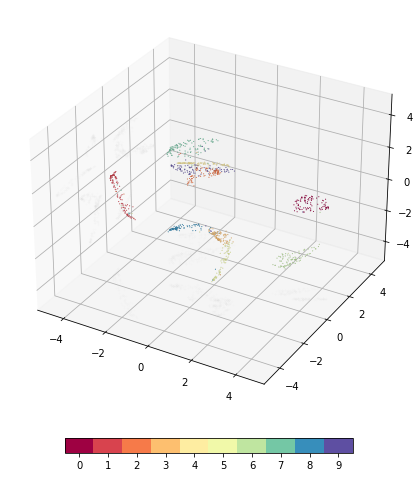

In [3]:
pymde.plot(tensor, 
           color_by=mnist.attributes['digits'][:limit],
         # marker_size=20
           )

# Creating graph and mesh

In [4]:
m = hmesh.Manifold().from_points(nparr)
m.cleanup()

g = graph.from_mesh(m)
g.cleanup()
jd.display(g)
# jd.display(m)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

# Skeleton using initial graph

In [5]:
skelet = graph.LS_skeleton(g)
skelet.cleanup()

In [6]:
jd.display(skelet)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

# Disconnecting all nodes, to make better graph

In [7]:
def disconnect_graph(gr: graph.Graph):
    for n in gr.nodes():
        for neighbour in gr.neighbors(n):
            gr.disconnect_nodes(n, neighbour)

# Finding good neighbours

In [8]:
from scipy.spatial import KDTree
searchtree = KDTree(g.positions())
# Check to see if anything not the same between the two lists
print(f"Length of lists: searchtree: {len(searchtree.data)}, graph: {len(g.positions())}")
print(
    "NodeID and searchtree identical: ", 
    all([sum(searchtree.data[index] - g.positions()[nodeid]) == 0. for index, nodeid in enumerate(g.nodes())])
)

Length of lists: searchtree: 1000, graph: 1000
NodeID and searchtree identical:  True


## Creating dict to lookup ids corroleating to vector as scipy's KDTree doesn't include the id's

In [9]:
pos = g.positions()
ids = g.nodes()
num_of_neighbours = 5
radius = 1

disconnect_graph(g)
# d, i = searchtree.query(test_pos, k=num_of_neighbours) # d = distance, i = indices to nparr
for n in tqdm(g.nodes()):
    # distance, indices = searchtree.query(pos[n], k=[num_of_neighbours])
    indices = searchtree.query_ball_point(pos[n], r=radius)
    for neighbour_id in [ids[x] for x in indices]:
        neighbours = g.neighbors(n)

        if neighbour_id not in neighbours:
            g.connect_nodes(n, neighbour_id)
graph.smooth(g)
jd.display(g)



100%|██████████| 1000/1000 [00:01<00:00, 829.05it/s]


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

In [10]:
new_skel = graph.LS_skeleton(g, sampling=False)
new_skel.cleanup()
graph.prune(new_skel)
jd.display(new_skel)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

In [11]:
graph.save("../Data/Skeletons/LocalSkeleton", new_skel)

True